## **Project:** Air Quality Index Prediction using machine learning

**Source:** Central Pollution Control Board, India (2020). Air Quality Data in India (2015 - 2020)  
**Date:** 10/25/24  
**Goal:** Create a basic prediction model and a feature explainer  

In [1]:
# Step 0. Load libraries and custom modules 
# Basics ---------------------------------------------------------------
import os
import logging
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import(
    train_test_split,
    GridSearchCV
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import(
    PowerTransformer,
    OneHotEncoder
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import(
    RandomForestRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    ConfusionMatrixDisplay
)
# Custom functions -----------------------------------------------------
def fill_na_with_median_or_zero(train_df, test_df, category_col, numeric_cols):
    train_df = train_df.copy()
    test_df = test_df.copy()
    for col in numeric_cols:
        medians = (
            train_df.groupby(category_col, observed=False)[col]
            .median().fillna(0)
        )
        train_df[col] = (
            train_df.groupby(category_col, observed=False)[col]
            .transform(lambda x: x.fillna(medians[x.name]))
        )
        test_df[col] = (
            test_df
            .apply(lambda row: medians[row[category_col]] 
                   if np.isnan(row[col]) else row[col], axis=1)
        )
    return train_df, test_df

### 1. Data loading

**Objective:** Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# Step 1. Load data ----------------------------------------------------
# 1.1 Read the data file and get a glimpse
df_city_day = pd.read_csv('../data/city_day.csv')
df_city_location = pd.read_csv('../data/city_location.csv')
df_raw = df_city_day.merge(df_city_location, on='City', how='left')
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
 16  Latitude    29531 non-null  float64
 17  Longitude   29531 non-null  float64
dtypes: float64(15), object(3)
memory usage: 4.1+ MB


None

In [3]:
# 1.2 Get a sample
display(df_raw.sample(10, random_state=2024).fillna('-'))

City        Date   PM2.5    PM10     NO    NO2    NOx    NH3  \
12434       Gurugram  2015-12-31       -       -  12.63  13.98  14.61      -   
0          Ahmedabad  2015-01-01       -       -   0.92  18.22  17.15      -   
12041          Delhi  2019-12-18   144.0  214.88  29.59  44.41  48.79  51.81   
4050        Amritsar  2019-11-01  154.49  235.28  17.73   9.94  27.64  12.81   
15462      Hyderabad  2017-06-03   13.78   42.98    8.4  19.42   6.83  14.37   
28765  Visakhapatnam  2018-05-28    25.1   76.72  10.74  30.18  24.95  12.93   
24709          Patna  2017-09-23       -       -      -      -      -      -   
14429       Guwahati  2020-02-01   123.8  184.52  28.23  10.06  57.12  18.14   
24449          Patna  2017-01-06  238.36       -  34.01  24.54  58.56      -   
12333      Ernakulam  2020-04-26   18.44   44.38  15.45      -  13.95  38.43   

         CO    SO2      O3 Benzene Toluene Xylene    AQI    AQI_Bucket  \
12434  1.43   5.41   28.88       -       -      -      -             -   
0      0.92  27.64  133.36     0.0    0.02    0.0      -             -   
12041  1.24   7.98   32.08    3.47   22.85   0.16  273.0          Poor   
4050   0.37  19.27   15.38    3.53    4.21    2.0  313.0     Very Poor   
15462  0.07   2.33   53.33    0.01    0.33   0.04  103.0      Moderate   
28765  0.48  13.46   13.69    6.47   15.26   2.56   56.0  Satisfactory   
24709  0.00      -       -     0.0     0.0    0.0      -             -   
14429  1.21  13.22   18.75    0.69       -      -  250.0          Poor   
24449  2.30  11.88    5.03    0.24    0.73    0.4  403.0        Severe   
12333  1.15   2.89       -    0.09    0.07    0.0   59.0  Satisfactory   

        Latitude  Longitude  
12434  28.457523  77.026344  
0      23.025800  72.587300  
12041  28.644800  77.216700  
4050   31.634000  74.875600  
15462  17.384100  78.456400  
28765  17.702900  83.218500  
24709  25.615400  85.101000  
14429  26.115103  91.703239  
24449  25.615400  85.101000  
12333   9.980000  76.280000

### 2. Data preprocessing
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [4]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using method chaining
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .assign(
        date = lambda df: pd.to_datetime(df['date']),
        quarter = lambda df: df['date'].dt.quarter.astype(str).map(lambda x: f'Q{x}')
    )
    .drop(['aqi_bucket'], axis=1)
    .set_index(['date'])
    .dropna(subset=['aqi'])
    .astype({'city':'category',
             'quarter':'category'})
)

In [5]:
# 2.2 Create the final dataset with the target in front
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['aqi'] + 
            [c for c in df_interim.columns.to_list() if c not in ['aqi']]
        )
    )
)

In [6]:
# 2.3 Display the info and a sample for the final dataset
display(df.info())
display(df.sample(10, random_state=2024))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24850 entries, 2015-01-29 to 2020-07-01
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   aqi        24850 non-null  float64 
 1   city       24850 non-null  category
 2   pm25       24172 non-null  float64 
 3   pm10       17764 non-null  float64 
 4   no         24463 non-null  float64 
 5   no2        24459 non-null  float64 
 6   nox        22993 non-null  float64 
 7   nh3        18314 non-null  float64 
 8   co         24405 non-null  float64 
 9   so2        24245 non-null  float64 
 10  o3         24043 non-null  float64 
 11  benzene    21315 non-null  float64 
 12  toluene    19024 non-null  float64 
 13  xylene     9478 non-null   float64 
 14  latitude   24850 non-null  float64 
 15  longitude  24850 non-null  float64 
 16  quarter    24850 non-null  category
dtypes: category(2), float64(15)
memory usage: 3.1 MB


None

aqi                city    pm25    pm10     no    no2    nox  \
date                                                                         
2020-04-24   69.0           Bengaluru   26.25   65.58   3.38  13.05  15.61   
2016-06-11   20.0           Bengaluru     NaN   21.74   2.11  10.14   6.31   
2018-12-28  131.0           Hyderabad   64.10  138.43   6.93  44.84  28.62   
2016-07-16   91.0           Ahmedabad   40.90     NaN   4.09  36.77  24.99   
2020-05-02   49.0             Kolkata   16.81   32.46   4.15  10.69  14.88   
2019-08-16  505.0           Ahmedabad   27.60   75.10  33.81  48.35  60.52   
2019-09-24   68.0  Thiruvananthapuram    4.78   22.30   1.43   3.09   1.95   
2018-11-09  243.0              Jaipur  108.86  256.31  62.22  34.38  87.80   
2020-05-26   47.0  Thiruvananthapuram   16.22   35.47   7.76  12.74  17.08   
2018-11-08   95.0  Thiruvananthapuram   49.17   73.19   5.07  13.16  10.13   

              nh3     co    so2     o3  benzene  toluene  xylene   latitude  \
date                                                                          
2020-04-24   9.74   0.75   6.54  34.36     0.59     3.18     NaN  12.971599   
2016-06-11    NaN   0.35   2.17    NaN      NaN      NaN     NaN  12.971599   
2018-12-28  13.36   0.62  16.12  36.78     3.63    25.25   22.15  17.384100   
2016-07-16    NaN   4.09  17.01    NaN     0.00     0.00    0.00  23.025800   
2020-05-02  12.49   0.39   5.57  30.12     2.15     7.01    0.49  22.572645   
2019-08-16    NaN  33.81  42.40  34.06     2.14    32.05    0.52  23.025800   
2019-09-24   1.16   1.13   2.08  20.74      NaN      NaN     NaN   8.524100   
2018-11-09  21.60   2.74  14.94  41.49     2.89     2.16     NaN  26.919600   
2020-05-26   6.18   0.62   5.93  25.07      NaN      NaN     NaN   8.524100   
2018-11-08   4.52   1.72   6.52  40.54      NaN      NaN     NaN   8.524100   

            longitude quarter  
date                           
2020-04-24  77.594563      Q2  
2016-06-11  77.594563      Q2  
2018-12-28  78.456400      Q4  
2016-07-16  72.587300      Q3  
2020-05-02  88.363892      Q2  
2019-08-16  72.587300      Q3  
2019-09-24  76.936600      Q3  
2018-11-09  75.787800      Q4  
2020-05-26  76.936600      Q2  
2018-11-08  76.936600      Q4

### 3. Exploratory Data Analysis
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [7]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.20, 
                                     stratify=df['city'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19880 entries, 2018-12-28 to 2020-04-25
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   aqi        19880 non-null  float64 
 1   city       19880 non-null  category
 2   pm25       19336 non-null  float64 
 3   pm10       14219 non-null  float64 
 4   no         19580 non-null  float64 
 5   no2        19565 non-null  float64 
 6   nox        18408 non-null  float64 
 7   nh3        14671 non-null  float64 
 8   co         19541 non-null  float64 
 9   so2        19395 non-null  float64 
 10  o3         19233 non-null  float64 
 11  benzene    17047 non-null  float64 
 12  toluene    15217 non-null  float64 
 13  xylene     7579 non-null   float64 
 14  latitude   19880 non-null  float64 
 15  longitude  19880 non-null  float64 
 16  quarter    19880 non-null  category
dtypes: category(2), float64(15)
memory usage: 2.5 MB


In [8]:
# 3.2 Get numerical and category summaries
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

count        mean         std      min        25%         50%  \
aqi        19880.0  166.059960  140.445329  13.0000  81.000000  118.000000   
pm25       19336.0   67.202445   62.548354   0.0400  28.967500   48.830000   
pm10       14219.0  118.012281   88.882257   0.0300  56.640000   96.250000   
no         19580.0   17.488900   21.987275   0.0300   5.670000    9.880000   
no2        19565.0   29.013259   24.655593   0.0200  11.970000   22.140000   
nox        18408.0   32.147326   30.173366   0.0000  13.070000   23.790000   
nh3        14671.0   23.904717   26.273490   0.0100   8.930000   16.150000   
co         19541.0    2.349816    7.113231   0.0000   0.590000    0.930000   
so2        19395.0   14.359213   17.428308   0.0100   5.720000    9.200000   
o3         19233.0   34.984062   21.835750   0.0400  19.310000   31.240000   
benzene    17047.0    3.410859   15.518626   0.0000   0.220000    1.280000   
toluene    15217.0    9.529769   20.698224   0.0000   1.020000    3.560000   
xylene      7579.0    3.600422    6.895726   0.0000   0.380000    1.410000   
latitude   19880.0   21.363570    6.493169   8.5241  16.566700   22.572645   
longitude  19880.0   79.610313    4.481464  72.5873  76.961632   78.456400   

                75%        max  
aqi        207.0000  1917.0000  
pm25        80.4950   914.9400  
pm10       149.6050   917.0800  
no          20.0325   287.1400  
no2         38.2900   362.2100  
nox         40.1800   293.1000  
nh3         30.4400   352.8900  
co           1.4700   175.8100  
so2         15.1600   186.0800  
o3          46.0600   257.7300  
benzene      3.3300   455.0300  
toluene     10.1700   454.8500  
xylene       4.0600   170.3700  
latitude    26.8500    31.6340  
longitude   83.2185    92.7179

count unique    top  freq
city     19880     26  Delhi  1599
quarter  19880      4     Q2  5655

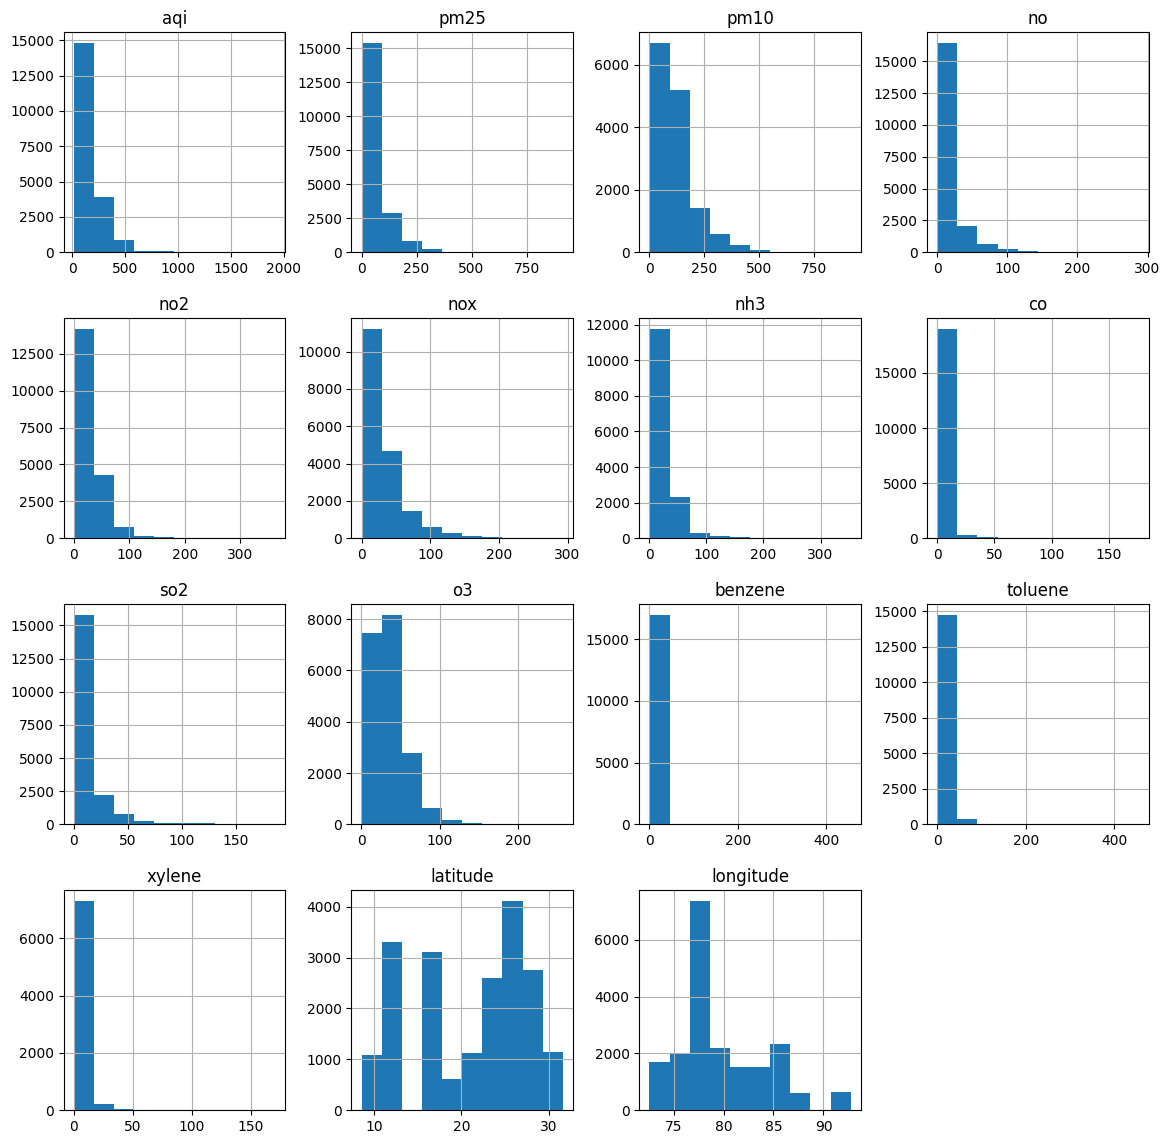

In [9]:
# 3.3 Perform univariate analysis - number
df_train.hist(figsize=(14,14))
plt.show()

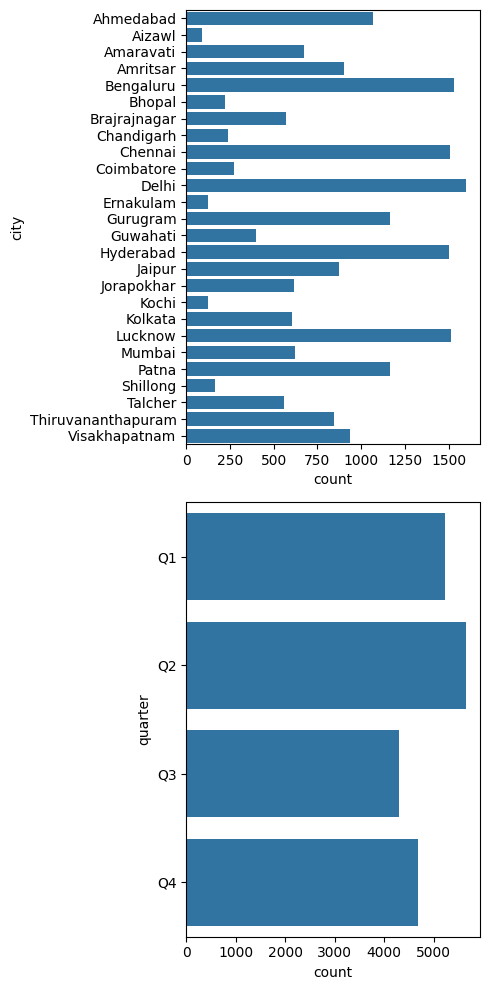

In [10]:
# 3.4 Perform univariate analysis - category
fig, ax = plt.subplots(2,1, figsize=(5,10))
axs = ax.flatten()
sns.countplot(data=df_train, y='city', ax=axs[0])
sns.countplot(data=df_train, y='quarter', ax=axs[1])
fig.tight_layout()
plt.show()

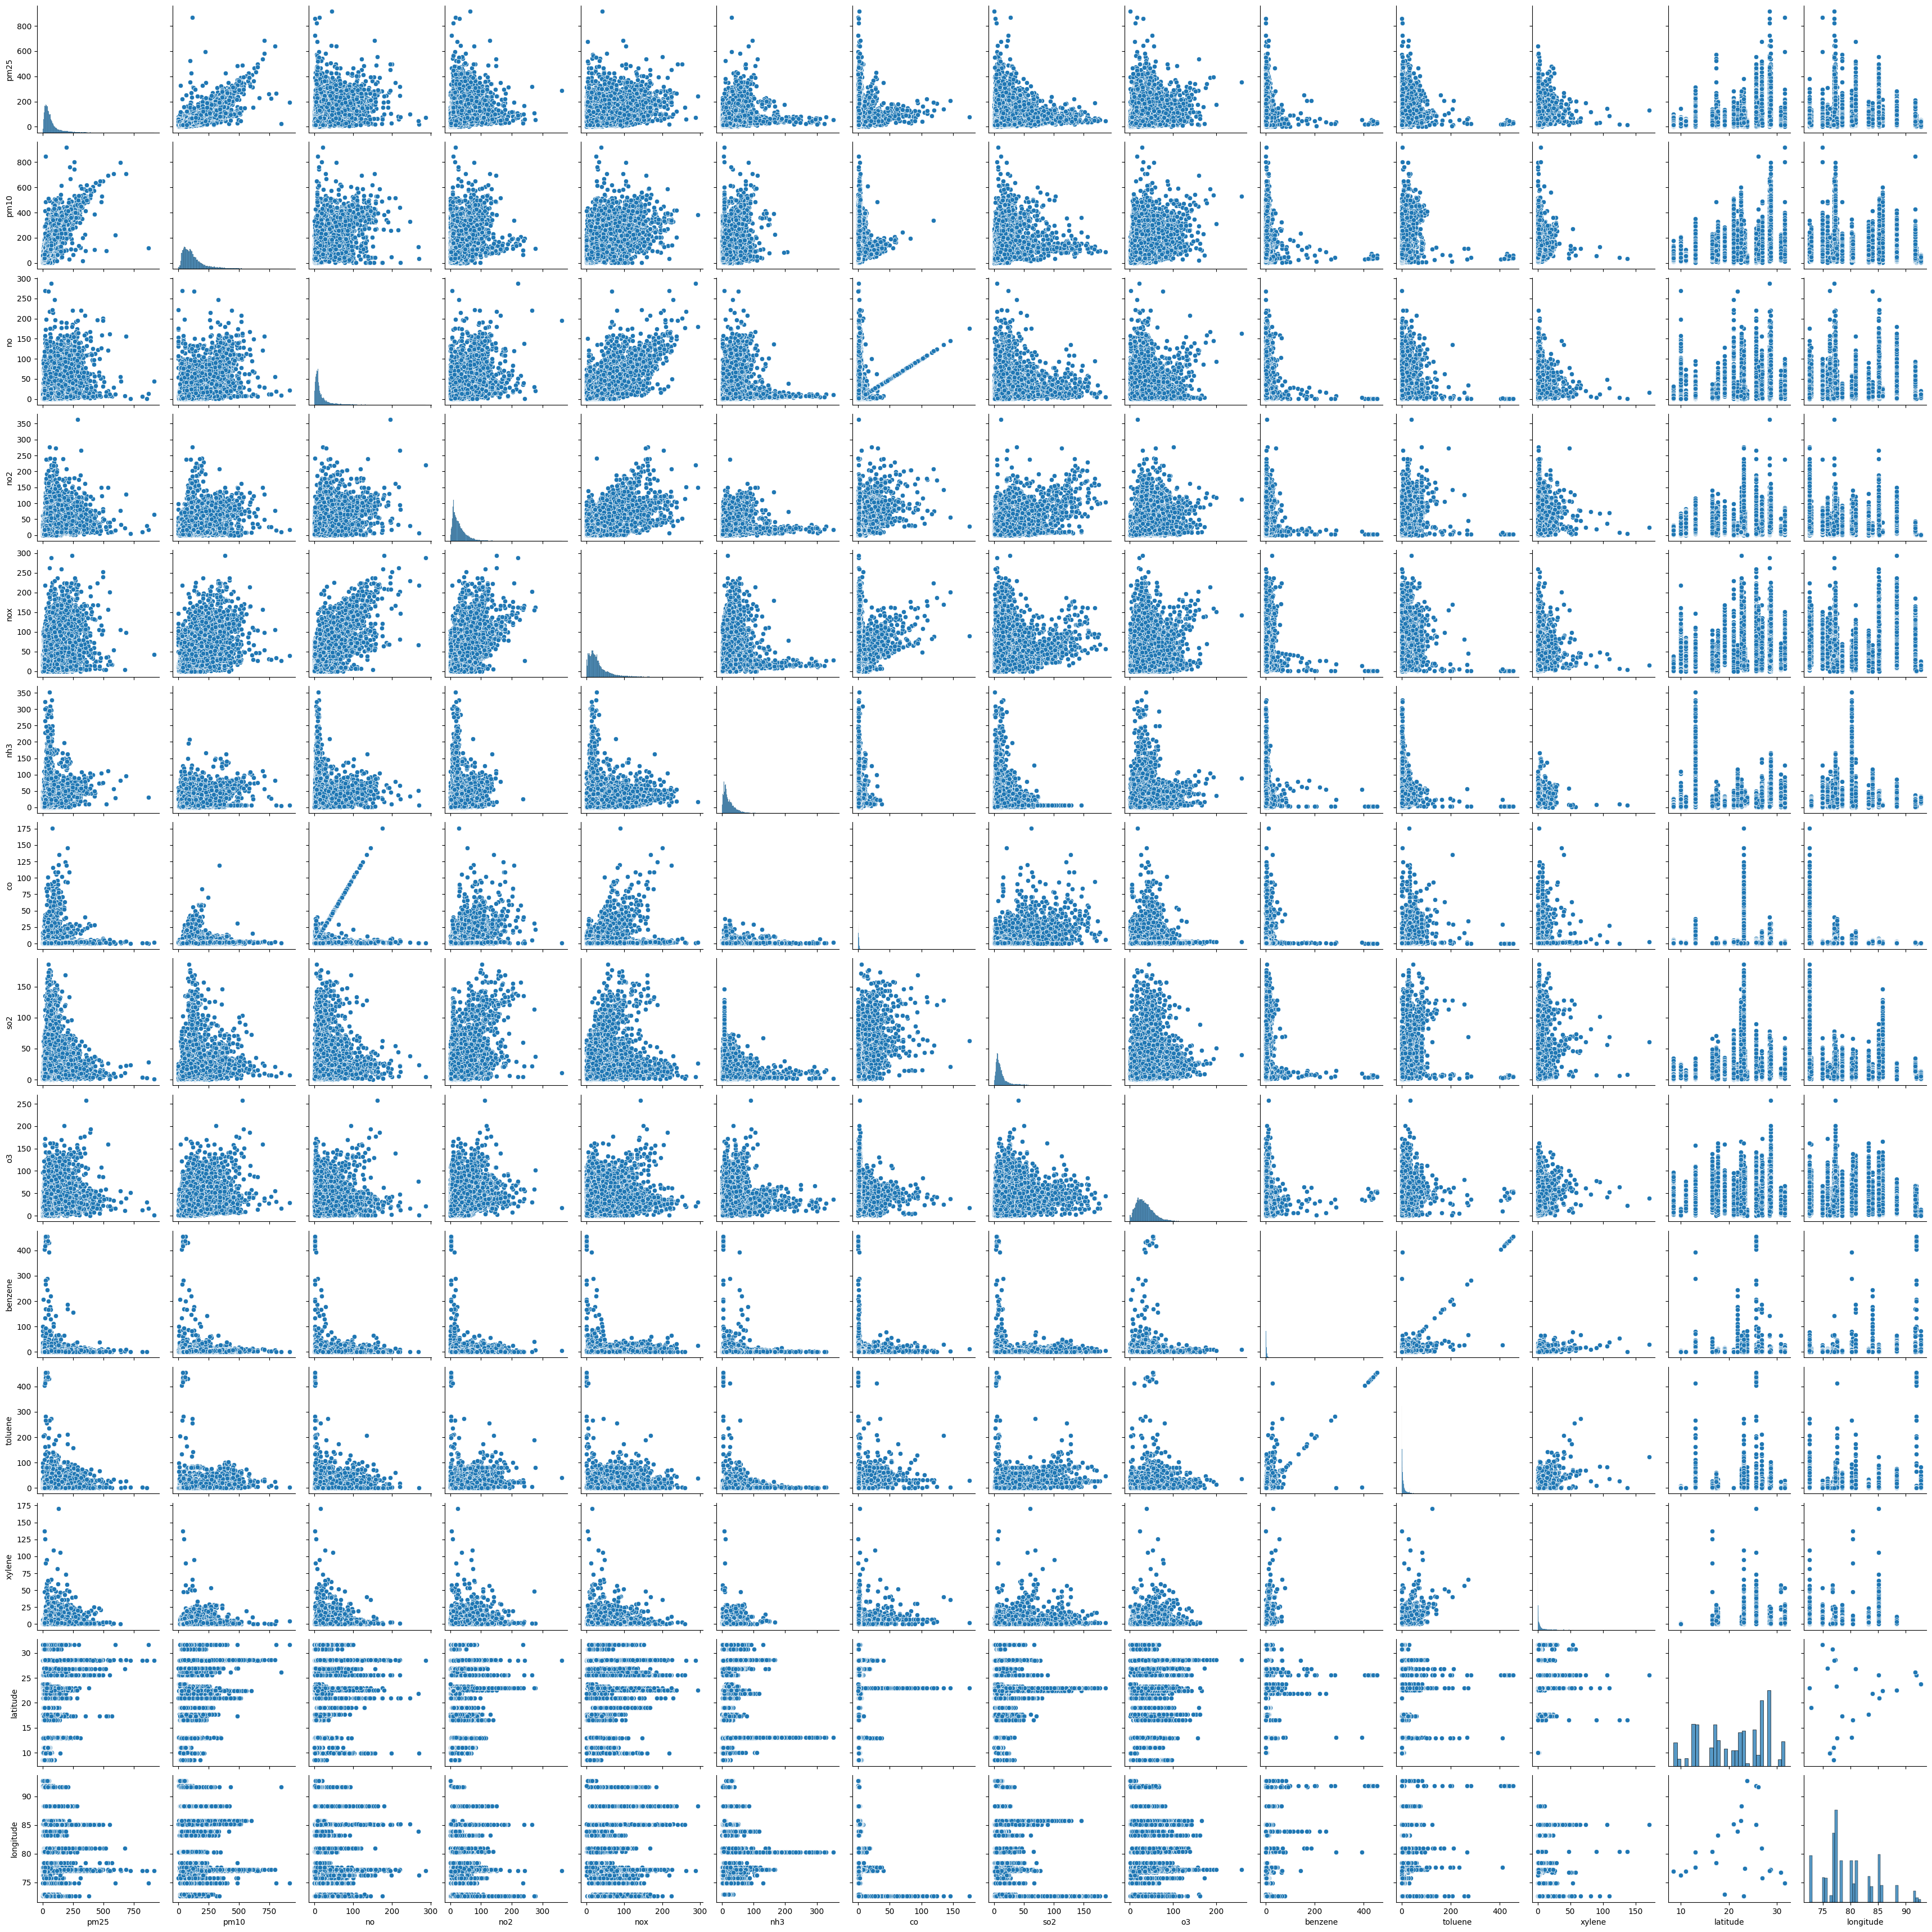

In [11]:
# 3.5 Perform bivariate analysis - Numerical without target
sns.pairplot(data=df_train.reset_index().drop(['aqi','date'], axis=1))
plt.show()

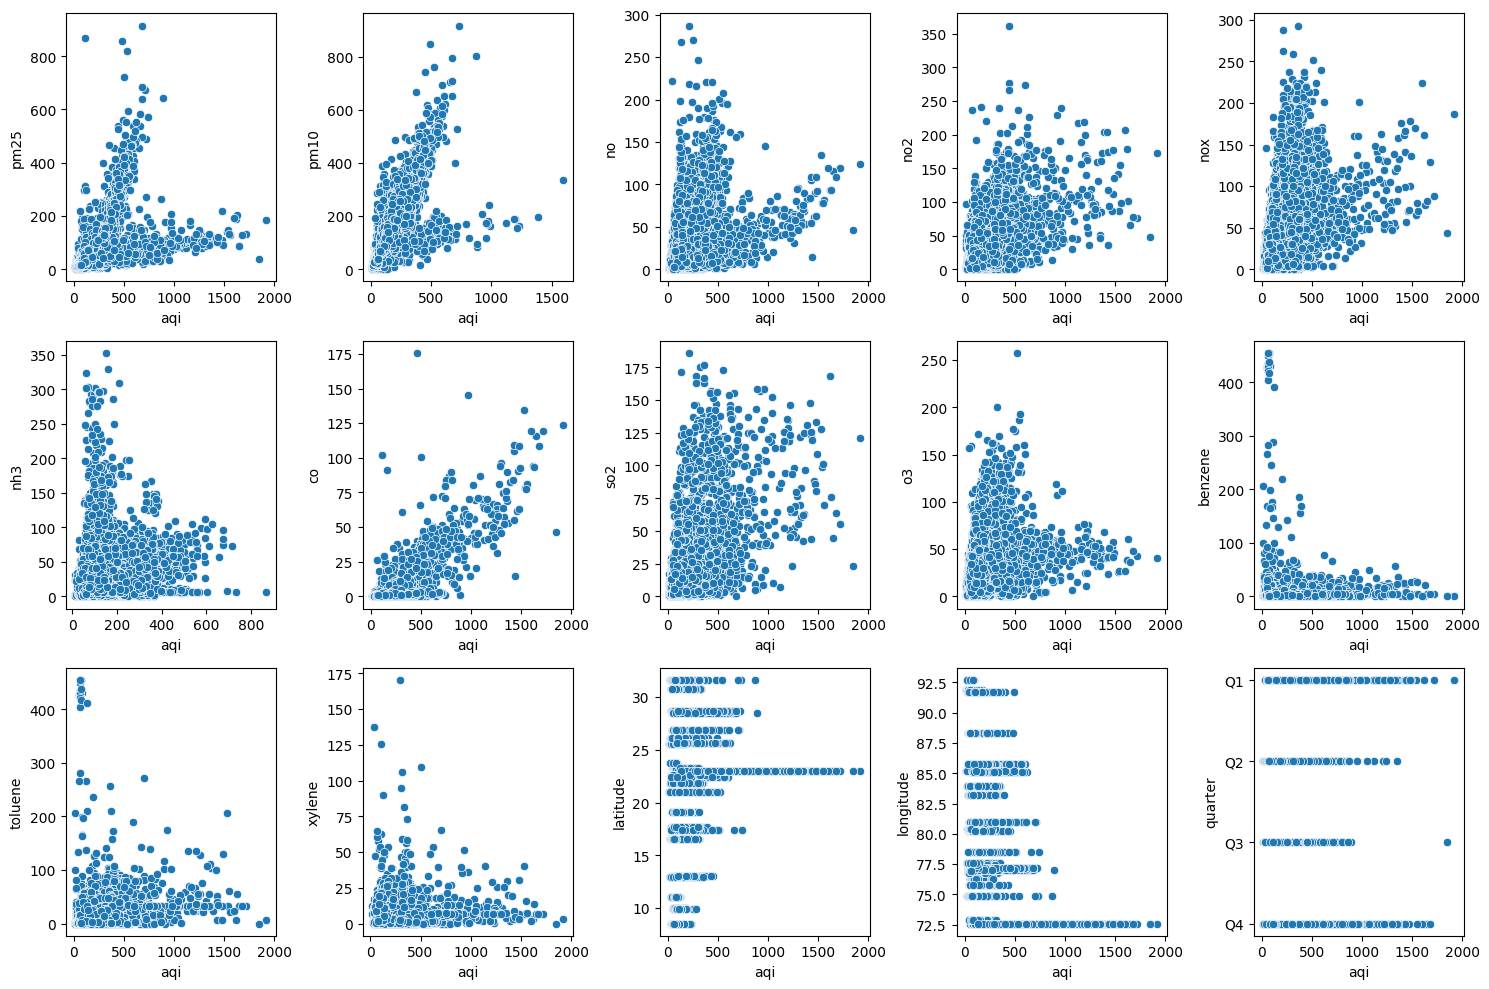

In [12]:
numeric_list = (
    df_train.reset_index()
    .drop(['city','date'],axis=1)
    .columns.tolist()[1:]
)
fig, ax = plt.subplots(3,5, figsize=(15,10))
j=0
axs = ax.flatten()
for i in numeric_list:
    sns.scatterplot(data=df_train.reset_index(), x='aqi', y=i, ax=axs[j])
    j+=1
plt.tight_layout()
plt.show()


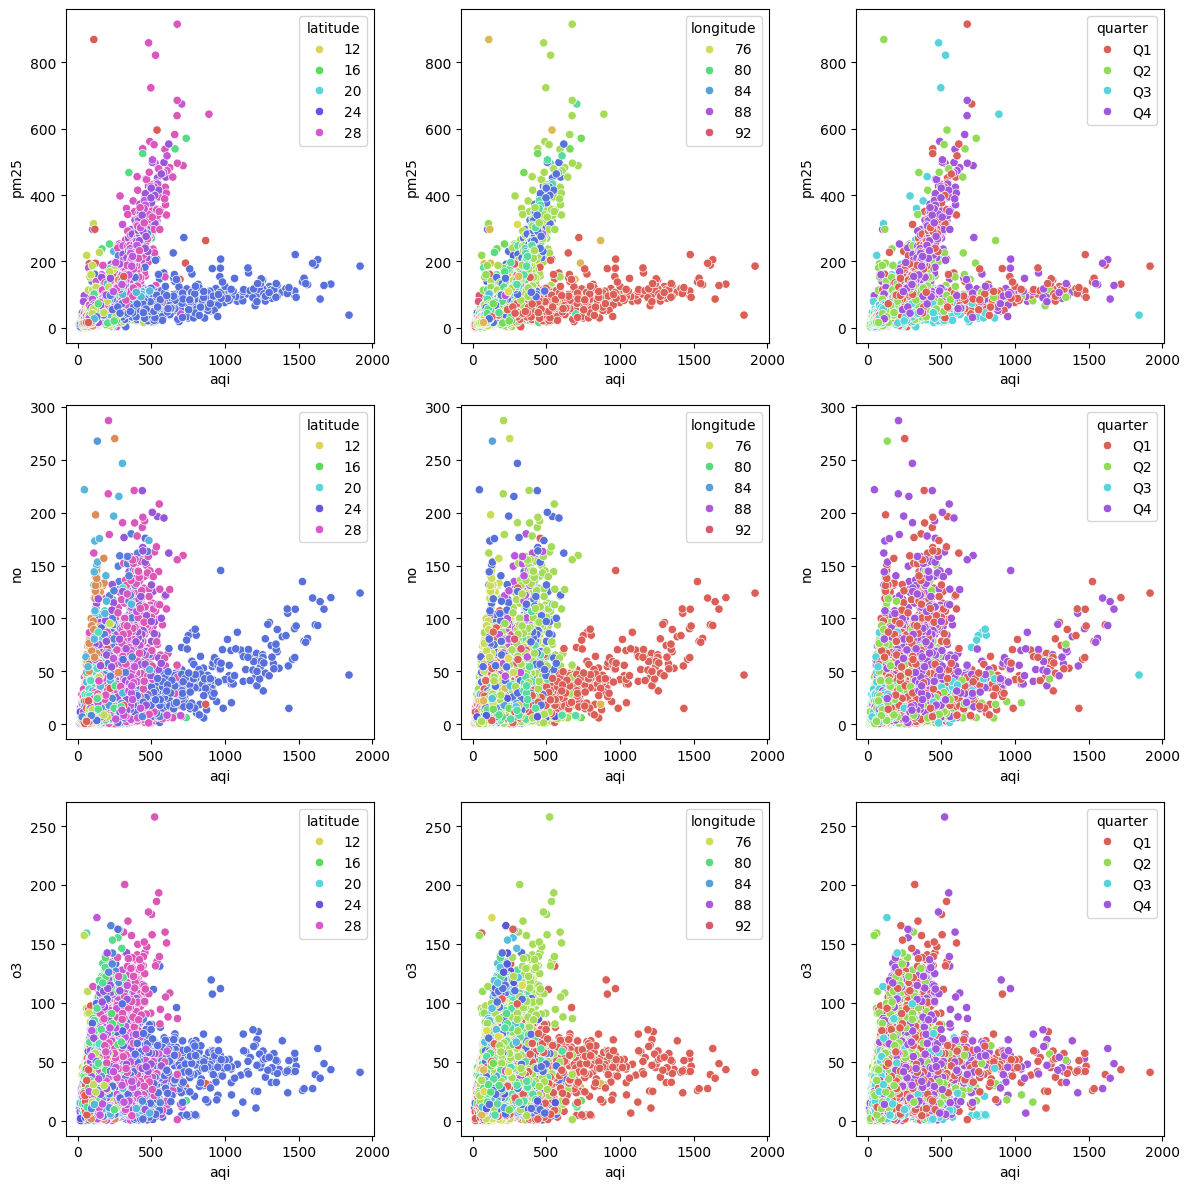

In [13]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
axs = ax.flatten()
hue_list = ['latitude','longitude','quarter'] * 3
y_list = ['pm25'] * 3 + ['no'] * 3 + ['o3'] * 3
for i in range(9):
    sns.scatterplot(
        data=df_train.reset_index(), x='aqi', y=y_list[i], 
        hue=hue_list[i], palette='hls', ax=axs[i])
plt.tight_layout()
plt.show()

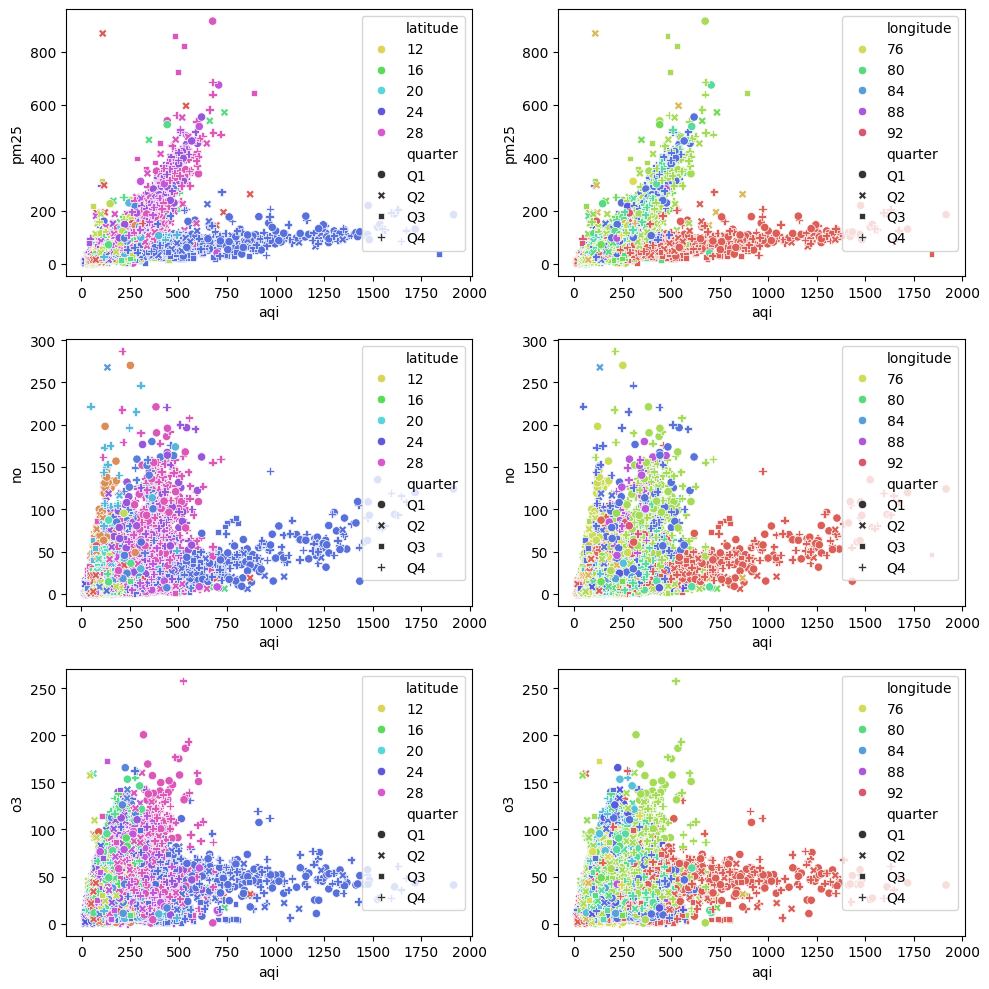

In [14]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
axs = ax.flatten()
y_list = ['pm25'] * 2 + ['no'] * 2 + ['o3'] * 2
hue_list = ['latitude','longitude'] * 3
for i in range(6):
    sns.scatterplot(
        data=df_train.reset_index(), 
        x='aqi', y=y_list[i], hue=hue_list[i], 
        palette='hls', style='quarter', ax=axs[i]
    )
plt.tight_layout()
plt.show()

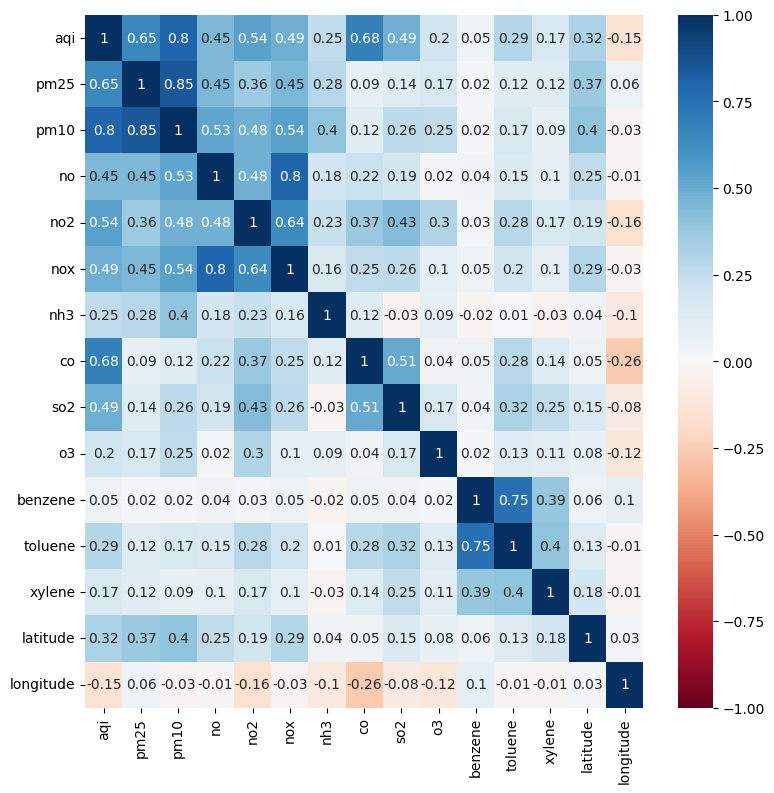

In [15]:
# 3.7 Perform correlation analysis
fig = plt.figure(figsize=(9,9))
sns.heatmap(
    df_train.select_dtypes('number').corr().round(2), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

### 4. Machine learning
**Objective:** Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [16]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.reset_index(drop=True).drop(['aqi'], axis=1)
y_train = df_train['aqi'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True).drop(['aqi'], axis=1)
y_test = df_test['aqi'].reset_index(drop=True)

In [17]:
# 4.2 For this model we can try two strategies: 
# A. Fill the NaNs with the median
# B. Fill the NaNs with the median based on city, then remove city
numerics = X_train.select_dtypes('number').columns.tolist()
X_train_b, X_test_b = fill_na_with_median_or_zero(X_train, X_test, 'city', numerics)
X_train_bf = X_train_b.drop(['city'], axis=1)
X_test_bf = X_test.drop(['city'], axis=1)

In [18]:
# 4.3 Create a pipeline for data
cat_cols = X_train_bf.select_dtypes('category').columns
num_cols = X_train_bf.select_dtypes('number').columns

cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer())
    #('minmax', MinMaxScaler())
])

processor = ColumnTransformer(transformers=[
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [19]:
# 4.4 Create a pipeline for model training
reg_rf = Pipeline([
    ('proc',processor),
    ('rfclf', RandomForestRegressor(random_state=2024))
])

In [20]:
# 4.5 Train the model 
reg_rf.fit(X_train_bf, y_train)

Pipeline(steps=[('proc',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['quarter'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer())]),
                                                  Index(['pm25', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene',
       'toluene', 'xylene', 'latitude', 'longitude'],
      dtype='object'))])),
                ('rfclf', RandomForestRegressor(random_state=2024))])

In [21]:
y_pred = reg_rf.predict(X_test_bf)

In [22]:
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2: {r2_score(y_test, y_pred)}')

Mean squared error: 1904.3300093340217
Root mean squared error: 43.63862978295746
R2: 0.9051383353250966


In [23]:
def map_aqi_bucket(x: float):
    if x <= 50:
        return 'Good'
    elif x<= 100:
        return 'Satisfactory'
    elif x<= 200:
        return 'Moderate'
    elif x<= 300:
        return 'Poor'
    elif x<= 400:
        return 'Very poor'
    else:
        return 'Severe'

In [24]:
y_test_bucket = [map_aqi_bucket(x) for x in y_test]
y_pred_bucket = [map_aqi_bucket(x) for x in y_pred]

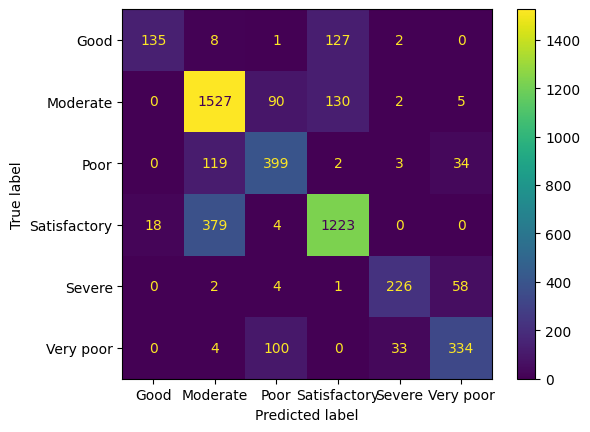

In [25]:

ConfusionMatrixDisplay.from_predictions(y_test_bucket, y_pred_bucket)
plt.show()

In [26]:
accuracy_score(y_test_bucket, y_pred_bucket)

0.7734406438631791

In [27]:
y_test.to_frame()

aqi
0      248.0
1      105.0
2       91.0
3     1155.0
4       39.0
...      ...
4965   269.0
4966   147.0
4967   147.0
4968   530.0
4969   155.0

[4970 rows x 1 columns]

### 5. Model saving
**Objective:** Save the model and some critical information we consider necessary

### 6. Notes
**Objective:** Add some comments or experiments done on experimenting